In [1]:
import torch
from model.cvae_model import VAE
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
device = 'cuda:0'

# vae = VAE([32, 16], 16, [16, 32], conditional=True, num_labels=19).to(device)
# vae.load_state_dict(torch.load('runs/semantic_kitti_unet32_spherical_transformer/cvae/model/cvae_model.pth', map_location=device))

# scene flow版
vae = VAE([32, 16], 16, [16, 32], conditional=True, num_labels=19, have_scene_flow=True).to(device)
vae.load_state_dict(torch.load('runs/semantic_kitti_unet32_spherical_transformer/cvae_scene_flow/model/cvae_model.pth', map_location=device))

<All keys matched successfully>

In [3]:
def gen_color(y):
    """
    y.shape = (n,)
    """
    color_map = [[245, 150, 100], [245, 230, 100], [150, 60, 30],
                 [180, 30, 80], [255, 0, 0], [30, 30, 255],
                 [200, 40, 255], [90, 30, 150], [255, 0, 255],
                 [255, 150, 255], [75, 0, 75], [75, 0, 175], 
                 [0, 200, 255], [50, 120, 255], [0, 175, 0],
                 [0, 60, 135], [80, 240, 150], [150, 240, 255], [0, 0, 255]]
    color_map = np.asarray(color_map, dtype=np.float32)
    res = np.zeros((len(y), 3))
    for i in range(19):
        mask = (y == i)
        res[mask] = color_map[i]
    return res

In [4]:
c = torch.randint(0, 19, (10000, ), dtype=torch.long, device=device)
z = torch.randn((c.shape[0], 16), device=device)
scene_flow = np.load('/mnt/Disk16T/chenhr/semantic_kitti/sequences/00/flow/000002.npy')[0:10000]
scene_flow = torch.as_tensor(scene_flow, device=device)
with torch.no_grad():
    # fea = vae.inference(z, c)
    fea = vae.inference(z, c, scene_flow)   # scene flow版

In [5]:
fea, c = fea.to('cpu').numpy(), c.to('cpu').numpy()
c_color = gen_color(c) / 255

/home/lindi/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


([], [])

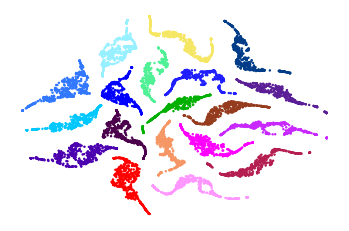

In [6]:
tsne = TSNE(init='pca', learning_rate='auto', n_iter=300)
low_f = tsne.fit_transform(fea)

plt.scatter(low_f[:, 0], low_f[:, 1], c=c_color, s=2)
plt.axis('off')
plt.xticks([])
plt.yticks([])
# plt.savefig('./epsc.png', dpi=800)